In [1]:
import os
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

from datetime import timedelta
from multiprocessing import cpu_count
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

############################## Write your code ##############################
##### Optional
# Import more if you may
# Note: If there is an import error when grading, you will get F
# Hint: Stick to the often used packages
#############################################################################

In [2]:
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

GPU = 0

device = torch.device(f'cuda:{GPU}' if torch.cuda.is_available() else 'cpu')

def fake_z(batch_size, noise, device):
    return torch.randn(batch_size, noise, device=device)

In [3]:
transform = transforms.Compose([
############################## Write your code ##############################
# Transform your data
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)

#############################################################################
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
############################## Write your code ##############################
##### Optional
# Change BATCH_SIZE if you may
BATCH_SIZE = 2 ** 8

# Change NUM_WORKERS if you may
if cpu_count() > 5:
    NUM_WORKERS = cpu_count() // 2
elif cpu_count() < 2:
    NUM_WORKERS = 0
else:
    NUM_WORKERS = 2
#############################################################################
    
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [5]:
############################## Write your code ##############################
# Build Generator
class Generator(nn.Module):
    def __init__(self, noise, hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=2, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(2*2*64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 28*28)
        

    def forward(self, x):
        x = x.view(-1, 1, 10, 10)
        #print("연산 전", x.size())
        x = self.pool(F.relu(self.conv1(x)))
        #print("conv1 연산 후", x.size())
        x = self.pool(F.relu(self.conv2(x)))
        #print("conv2 연산 후", x.size())
        x = x.view(-1, 2*2*64)
        #print("차원 감소 후", x.size())
        x = F.dropout(F.relu(self.fc1(x)), 0.1)
        #print("fc1 연산 후", x.size())
        x = F.dropout(F.relu(self.fc2(x)), 0.1)
        #print("fc2 연산 후", x.size())
        output = torch.tanh(self.fc3(x))
        return output
#############################################################################

In [6]:
############################## Write your code ##############################
# Build Discriminator
class Discriminator(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=2, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7*7*64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        #print("연산 전", x.size())
        x = self.pool(F.relu(self.conv1(x)))
        #print("conv1 연산 후", x.size())
        x = self.pool(F.relu(self.conv2(x)))
        #print("conv2 연산 후",x.size())
        x = x.view(-1, 7*7*64)
        #print("차원 감소 후", x.size())
        x = F.dropout(F.leaky_relu(self.fc1(x)), 0.1)
        #print("fc1 연산 후", x.size())
        x = F.dropout(F.leaky_relu(self.fc2(x)), 0.1)
        #print("fc2 연산 후", x.size())
        output = torch.sigmoid(self.fc3(x))
        return output
#############################################################################

In [7]:
############################## Write your code ##############################
# Set your model(s), optimizer(s), and loss function(s)

noise = 100
hidden = 256

generator = Generator(noise, hidden).to(device)
discriminator = Discriminator(hidden).to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr = 0.0002)
dis_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002)


criterion = nn.BCELoss().to(device)
#############################################################################

Epoch [5/200] Elapsed time: 0:00:49.104232
Epoch [10/200] Elapsed time: 0:01:39.510124
Epoch [15/200] Elapsed time: 0:02:29.398108
Epoch [20/200] Elapsed time: 0:03:19.362245


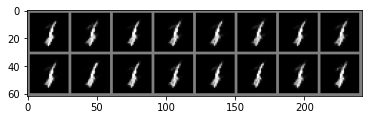

Epoch [25/200] Elapsed time: 0:04:09.257706
Epoch [30/200] Elapsed time: 0:04:59.001356
Epoch [35/200] Elapsed time: 0:05:48.556611
Epoch [40/200] Elapsed time: 0:06:38.238329


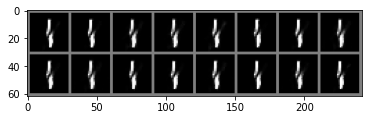

Epoch [45/200] Elapsed time: 0:07:28.069931
Epoch [50/200] Elapsed time: 0:08:17.790139
Epoch [55/200] Elapsed time: 0:09:07.371510
Epoch [60/200] Elapsed time: 0:09:56.991407


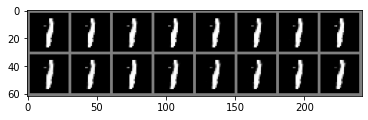

Epoch [65/200] Elapsed time: 0:10:47.263266
Epoch [70/200] Elapsed time: 0:11:37.441621
Epoch [75/200] Elapsed time: 0:12:27.690023
Epoch [80/200] Elapsed time: 0:13:17.503714


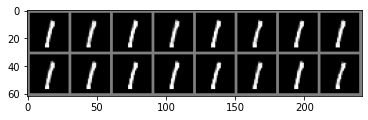

Epoch [85/200] Elapsed time: 0:14:07.244903
Epoch [90/200] Elapsed time: 0:14:56.934084
Epoch [95/200] Elapsed time: 0:15:46.634597
Epoch [100/200] Elapsed time: 0:16:36.255368


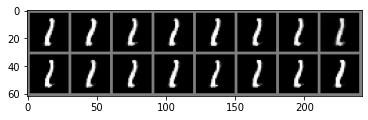

Epoch [105/200] Elapsed time: 0:17:25.893352
Epoch [110/200] Elapsed time: 0:18:15.720695
Epoch [115/200] Elapsed time: 0:19:05.501626
Epoch [120/200] Elapsed time: 0:19:54.937734


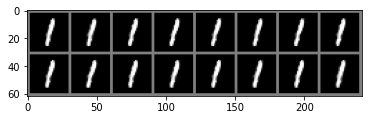

Epoch [125/200] Elapsed time: 0:20:44.615163
Epoch [130/200] Elapsed time: 0:21:34.301298
Epoch [135/200] Elapsed time: 0:22:24.192702
Epoch [140/200] Elapsed time: 0:23:13.705805


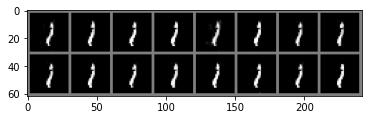

Epoch [145/200] Elapsed time: 0:24:03.225628
Epoch [150/200] Elapsed time: 0:24:53.025301
Epoch [155/200] Elapsed time: 0:25:43.508967
Epoch [160/200] Elapsed time: 0:26:34.024271


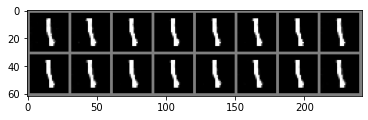

Epoch [165/200] Elapsed time: 0:27:24.346273
Epoch [170/200] Elapsed time: 0:28:13.737039
Epoch [175/200] Elapsed time: 0:29:03.229149
Epoch [180/200] Elapsed time: 0:29:52.822957


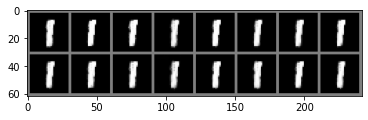

Epoch [185/200] Elapsed time: 0:30:42.314642
Epoch [190/200] Elapsed time: 0:31:31.614106
Epoch [195/200] Elapsed time: 0:32:20.985731
Epoch [200/200] Elapsed time: 0:33:10.294723


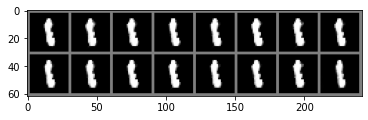

In [8]:
############################## Write your code ##############################
##### Optional
# Change the training process below so it would fit your model
# Note: You must print 16 generated images every 20 epochs to show progress
EPOCHS = 200

start = time.time()

for ep in range(EPOCHS):

    generator.train()
    discriminator.train()

    for image, _ in trainloader:
        batch_size = image.size(0)

        image = image.to(device)
 
        real_label = torch.ones(batch_size).view(-1, 1).to(device)
        fake_label = torch.zeros(batch_size).view(-1, 1).to(device)

        dis_optimizer.zero_grad()

        real_output = discriminator(image.view(-1, 28 * 28))
        fake_output = discriminator(generator(fake_z(batch_size, noise, device)))
        
        real_loss = criterion(real_output, real_label)
        fake_loss = criterion(fake_output, fake_label)
        dis_loss = real_loss + fake_loss
  
        dis_loss.backward()
        dis_optimizer.step()

        gen_optimizer.zero_grad()
  
        fake_output = discriminator(generator(fake_z(batch_size, noise, device)))
  
        gen_loss = criterion(fake_output, real_label)
  
        gen_loss.backward()
        gen_optimizer.step()

    # Print time spent every 5 epochs
    if (ep + 1) % 5 == 0:
        print('Epoch [{}/{}] Elapsed time: {}'.format(ep + 1, EPOCHS, timedelta(seconds=time.time() - start)))

    # Generate 16 images every 20 epochs
    if (ep + 1) % 20 == 0:
        discriminator.eval()
        generator.eval()

        with torch.no_grad():
            image = make_grid(generator(fake_z(16, noise, device)).view(-1, 1, 28, 28).detach().cpu())
            image = (image + 1) / 2
            image = image.numpy()
            image = np.transpose(image, (1, 2, 0))
            plt.imshow(image)
            plt.show()
#############################################################################